In [2]:
from collections import defaultdict
from Bio.SeqIO.FastaIO import SimpleFastaParser as sfp
from Bio import SeqIO, SearchIO, Entrez
import subprocess as sp
import seaborn as sns
import numpy as np
import pandas as pd
import os, glob, math, re, gzip
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

In [5]:
def cmdir(path):
    if not os.path.isdir(path):
        os.mkdir(path)

def scaffold(gene):
    if gene != "None":
        try: return re.search("(.+?)_[0-9]+$", gene).group(1)
        except: print(gene)

def sbatch(name, cpus, cmd):
    return "sbatch -J %s -p serc -t 1- -c %d --mem %dG --wrap '%s'" %(name, cpus, cpus*8, cmd)

In [6]:
ocdir = "/scratch/groups/dekas/OC17_metagenomics_2022/"
rootdir = "/scratch/users/ajaffe/deepeco/"
cmdir(rootdir + "diversity")

# oc17

### read in redundant data

In [4]:
# genomes
nr_genomes = pd.read_csv(rootdir + "tables/nonredundant_genome_info.tsv", sep="\t")
nr_genomes.head(2)

,genome,classification,checkm_completeness,checkm_redundancy,primary_cluster,secondary_cluster,representative,scluster_rubisco_set,phylum
0,OceanDNA-b21631,d__Bacteria;p__Patescibacteria;c__Gracilibacte...,82.99,2.48,1,1_0,True,II_III_II_III,d__Bacteria_p__Patescibacteria
1,OceanDNA-b21628,d__Bacteria;p__Patescibacteria;c__Gracilibacte...,79.21,2.09,3,3_0,True,II_III_II_III,d__Bacteria_p__Patescibacteria


In [7]:
# genes
genes = pd.read_csv(rootdir + "tables/redundant_rubisco_info.tsv", sep="\t")
genes.head(2)

,cluster_name,cluster_size,gene,is_centroid,hmm,score,scaffold,bin,sequence,passes_threshold_specific,graftm_placement,graft_placement_parsed,curated_rubisco_form
0,DPECO_0,1,JASLMP010000001.1_22,True,II_II,705.8,JASLMP010000001.1,GCA_030746445.1_ASM3074644v1_genomic,MDQSNRYADLSLDEDTLIAEGKHILVAYTXXXXNRYADLSLDEDTL...,True,Root; Bona_Fide; II; II_graftm_1,II_II,II_II
1,DPECO_1,3,OceanDNA-b32625_00132_3,True,I,321.2,OceanDNA-b32625_00132,OceanDNA-b32625,MVKDVDQLPGSLKKAMEDKGISASELARECGVSMASLSRILSGQVN...,False,Root; Bona_Fide,Root; Bona_Fide,IV


In [9]:
# metabolisms
pathways = pd.read_csv(rootdir + "tables/metabolic_pathway_info.tsv", sep="\t")
pathways.head(2)

,function,genome_name,hit_count,hit_total,hit_perc,hit_kos,hit_ids,count_threshold
0,Aerobic Hydrogen Oxidation,MARD_SAMEA2272692_REFG_MMP2272692,1,1,100.0,"NiFe hydrogenase (1d, 1l, 2a)",MARD_MMP2272692_REFG-scaffold_10_10,1
1,Aerobic Hydrogen Oxidation,MARD_SAMEA3214536_REFG_MMP3214536,1,1,100.0,"NiFe hydrogenase (1d, 1l, 2a)",MARD_MMP3214536_REFG-scaffold_171_4,1


In [7]:
# environmental
environmental = pd.read_csv(rootdir + "tables/urea_supp_tables_s1.tsv", sep="\t")
environmental["depth_neg"] = environmental["depth"].apply(lambda x: x*-1)
environmental.head()

,site,depth,date_collected,latitude,longitude,Temperature (ºC),Salinity,Fluorescence,Dissolved_oxygen (saturation %),Average_nitrate_concentration (µM),SD_nitrate_concentration,Average_urea_concentration (nM),SD_urea_concentration,Ammonium_concentration (nM),SD_Ammonium_concentration,depth_neg
0,OC1,50,14/3/2017,37.134378,-122.54423,10.0446,33.6487,0.2114,48.633,20.525820,0.151450,1063.0,35.355340,0.000000,6.149154,-50
1,OC2,50,19/3/2017,37.036683,-122.70133,10.8594,33.4433,0.7755,60.952,16.920420,0.403866,20.5,17.677670,30.435195,11.228940,-50
2,OC2,150,19/3/2017,37.036683,-122.70133,8.4977,33.9246,0.1308,44.926,22.739040,0.252417,20.5,17.677670,17.966564,6.427914,-150
3,OC2,500,19/3/2017,37.036683,-122.70133,6.3530,34.2139,0.1308,7.741,34.983140,0.605800,53.0,7.071068,134.718829,41.796317,-500
4,OC3,50,22/3/2017,36.799083,-122.97433,12.8669,33.0063,0.9098,96.572,2.320311,0.151450,71.0,10.606600,367.518730,4.535918,-50


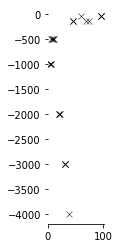

In [8]:
plt.figure(figsize=[1,4])
sns.scatterplot(x="Dissolved_oxygen (saturation %)", 
                y="depth_neg", data=environmental.query("site!='OC1'"), color='black', marker="x")
sns.despine(left=True)
plt.ylabel("")
plt.xlabel("")
sns.despine(bottom=False, left=True)
plt.savefig(rootdir + "figures/oxygen.svg", format="svg", 
            dpi=300,  bbox_inches="tight", facecolor="white")

### integrate genome sets

In [ ]:
cmdir(rootdir + "genomes/merged_drep")
cmdir(rootdir + "genomes/merged")

In [ ]:
for key, row in nr_genomes.iterrows():
    
    # locate the file
    gpath = rootdir + "genomes/first_pass/%s.fa" %(row["genome"])
    
    with open(rootdir + "genomes/merged/" + row["genome"] + ".fa", "w") as out:
        for record in sfp(open(gpath)):
            out.write(">%s\n%s\n" %(record[0], record[1]))

In [ ]:
prelim = pd.read_csv(ocdir + "tables/prelim_genomes_v2.tsv", sep="\t")

for key, row in prelim.iterrows():
    gpath = ocdir + "genomes/prelim_genomes/" + row["user_genome"] + ".fa"
    with open(rootdir + "genomes/merged/" + row["user_genome"] + ".fa", "w") as out:
        for record in sfp(open(gpath)):
            out.write(">%s\n%s\n" %(record[0], record[1]))

In [32]:
quality = pd.concat([
        nr_genomes[["genome", "checkm_completeness", "checkm_redundancy"]],
        prelim[["user_genome", "checkm_completeness", "checkm_redundancy"]].rename(columns={"user_genome":"genome"})
])
quality["genome"] = quality["genome"].apply(lambda x: x + ".fa")
quality.columns = ["genome", "completeness", "contamination"]
quality.to_csv(rootdir + "genomes/merged_drep/genomeInformation.csv", index=False)

In [33]:
call = "dRep dereplicate %s -sa 0.95 -p 20 -comp 50 -con 10 -d -g %s --genomeInfo %s" %(rootdir + \
    "/genomes/merged_drep/", rootdir + "/genomes/merged/*fa",
    rootdir + "genomes/merged_drep/genomeInformation.csv")
cmd = sbatch("drep", 20, call)
print(cmd)

sbatch -J drep -p serc -t 1- -c 20 --mem 160G --wrap 'dRep dereplicate /scratch/users/ajaffe/deepeco//genomes/merged_drep/ -sa 0.95 -p 20 -comp 50 -con 10 -d -g /scratch/users/ajaffe/deepeco//genomes/merged/*fa --genomeInfo /scratch/users/ajaffe/deepeco/genomes/merged_drep/genomeInformation.csv'


### select representatives

In [ ]:
cmdir(rootdir + "genomes/oc17_strict")

In [9]:
drep = pd.read_csv(rootdir + "genomes/merged_drep/data_tables/Cdb.csv")
drep["representative"] = drep["genome"].apply(lambda x: x in \
    [os.path.basename(item) for item in glob.glob(rootdir + "genomes/merged_drep/dereplicated_genomes/*")])
drep = drep.merge(pd.read_csv(rootdir + "genomes/merged_drep/genomeInformation.csv"), how="left")
drep.head()

,genome,secondary_cluster,threshold,cluster_method,comparison_algorithm,primary_cluster,representative,completeness,contamination
0,GCA_030751255.1_ASM3075125v1_genomic.fa,1_0,0.05,average,fastANI,1,True,57.58,6.54
1,TARA_SAMEA2620106_METAG_PKBHHHJA.fa,2_0,0.05,average,fastANI,2,True,83.64,0.00
2,TARA_SAMEA2621099_METAG_IDGDEHDE.fa,3_0,0.05,average,fastANI,3,True,96.36,0.00
3,TARA_SAMN05326646_METAG_PSW00024.fa,4_0,0.05,average,fastANI,4,True,90.57,1.68
4,OceanDNA-b32631.fa,5_0,0.05,average,fastANI,5,True,70.59,0.84


In [10]:
selected = []
reos = [item + ".fa" for item in nr_genomes["genome"].to_list()]

for secondary_cluster in drep["secondary_cluster"].unique():
    
    table = drep[drep["secondary_cluster"]==secondary_cluster]
    
    reo = False
    for genome in table["genome"].to_list():
        if genome in reos:
            reo=True
    
    if reo == True:
        
        subtable = table[table["genome"].isin(reos)]\
            .sort_values("completeness", ascending=False)
        # selects on REOs that cluster with A*
        if len(subtable) != len(table):
            selected.append(subtable["genome"].iloc[0])
        
    else:
        rep = table.query("representative==True")["genome"].iloc[0]
        selected.append(rep)

for select in selected:
    gpath = rootdir + "genomes/merged/" + select
    with open(rootdir + "genomes/oc17_strict/" + select, "w") as out:
        for record in sfp(open(gpath)):
            out.write(">%s\n%s\n" %(record[0], record[1]))

### remap reads

In [ ]:
cmdir(rootdir + "diversity/remapping_strict")

In [ ]:
# combine genomes
with open(rootdir + "diversity/remapping_strict/all_genomes.fna", "w") as out:
    for genome in glob.glob(rootdir + "genomes/oc17_strict/*"):
        for record in sfp(open(genome)):
            out.write(">%s\n%s\n" %(record[0], str(record[1])))

In [13]:
reads = []

# get all sample prefixes
prefixes = set([os.path.basename(file).split("_")[0] for file in 
               glob.glob(ocdir + "trimmed_reads/*R*_trimmed.fastq.gz")])

# get reads and make a tuple for each sample - (fwd, rev)
for prefix in prefixes:
    fwd, rev = sorted(glob.glob(ocdir + "trimmed_reads/" + prefix + "*R*_trimmed.fastq.gz"))
    reads.append((fwd,rev))
    
reads[0]

('/scratch/groups/dekas/OC17_metagenomics_2022/trimmed_reads/500m150m_R1_trimmed.fastq.gz',
 '/scratch/groups/dekas/OC17_metagenomics_2022/trimmed_reads/500m150m_R2_trimmed.fastq.gz')

In [ ]:
with open(rootdir + "/diversity/remapping_strict/remapGenomes.sh","w") as outfile:
    
    #build bt index
    call = "bowtie2-build %s %s" %(rootdir + "/diversity/remapping_strict/all_genomes.fna", \
        rootdir + "diversity/remapping_strict/all_genomes.idx")
    outfile.write(call + "\n")
    
    for read_tuple in reads:

        # read shorthand
        rcode = "R" + os.path.basename(read_tuple[0]).split("_")[0]
        filecode = rootdir + "/diversity/remapping_strict/genomes_" + rcode
        # generate mapping
        mapping = "bowtie2 -p 20 -x " + rootdir + "/diversity/remapping_strict/all_genomes.idx -1 " + \
            read_tuple[0] + " -2 " + read_tuple[1] + " 2> " + filecode + ".log" + \
            " | shrinksam | samtools view -S -b > " + filecode + ".bam"
        # generate sorted bam + idx
        sort = "samtools sort --threads 20 " + filecode + ".bam > " + filecode + ".sorted.bam"
        index = "samtools index -@ 20 " + filecode + ".sorted.bam"
        outfile.write(sbatch("map", 20, "%s && %s && %s") %(mapping, sort, index) + "\n")

In [ ]:
coverm = "coverm genome -t 20 --genome-fasta-directory %s -x fa --min-covered-fraction 0 --min-read-percent-identity 95 --output-format sparse -b %s -m count mean covered_fraction length > %s" %(rootdir + "genomes/oc17_strict/", \
    rootdir + "diversity/remapping_strict/*sorted.bam", rootdir + "/tables/oc17_genome_coverage_strict.csv")
print(coverm)

In [38]:
cmd = "rclone copy %s %s" %(rootdir + "/tables/oc17_genome_coverage_strict.csv", "drive:oc17/tables/")
print(cmd)

rclone copy /scratch/users/ajaffe/deepeco//tables/oc17_genome_coverage_strict.csv drive:oc17/tables/


### compute genome coverage

In [11]:
# read in genome coverage info
coverage_info = pd.read_csv(rootdir + "/tables/oc17_genome_coverage_strict.csv", sep="\t")
# filter out for covered fraction
coverage_info = coverage_info[coverage_info["Covered Fraction"]>=0.50]
# compute relative coverage
total_sample_cov = coverage_info.groupby("Sample", as_index=False).agg({"Mean":"sum"}).rename(columns={"Mean":"total_sample_cov"})
coverage_info = coverage_info.merge(total_sample_cov, how="left")
coverage_info["perc_relative_cov"] = coverage_info.apply(lambda x: x["Mean"]/x["total_sample_cov"] * 100, axis=1)
# subset to those with rubisco
reos_trimmed = [reo.strip(".fa") for reo in reos]
coverage_info_subset = coverage_info[coverage_info["Genome"].isin(reos_trimmed)]
coverage_info_subset.head()

,Sample,Genome,Read Count,Mean,Covered Fraction,Length,total_sample_cov,perc_relative_cov
3,genomes_R3000m1000m.sorted,OC5_3000m_MAG_74,1520915,145.145800,0.995235,1488377,10154.927332,1.429314
36,genomes_R3000m1000m.sorted,OC3_1000m_MAG_153,183212,17.388412,0.997945,1501000,10154.927332,0.171231
71,genomes_R3000m1000m.sorted,OC4_3000m_MAG_63,34106,3.179344,0.691415,1581161,10154.927332,0.031308
76,genomes_R3000m1000m.sorted,OceanDNA-b43084,269462,32.590225,0.885189,1201928,10154.927332,0.320930
84,genomes_R3000m1000m.sorted,OceanDNA-b17318,234638,8.945028,0.940585,3100902,10154.927332,0.088086


In [12]:
merged = coverage_info_subset.merge(nr_genomes[["genome", "scluster_rubisco_set", "classification"]], \
                                    how="left", left_on="Genome", right_on="genome").drop("genome", axis=1).fillna("None")
merged["site"] = merged["Sample"].apply(lambda x: re.search("genomes_R([0-9]+m).+", x).group(1))
merged["depth"] = merged["Sample"].apply(lambda x: -1*int(re.search("genomes_R[0-9]+m([0-9]+)m.+", x).group(1)))
merged.head()

,Sample,Genome,Read Count,Mean,Covered Fraction,Length,total_sample_cov,perc_relative_cov,scluster_rubisco_set,classification,site,depth
0,genomes_R3000m1000m.sorted,OC5_3000m_MAG_74,1520915,145.145800,0.995235,1488377,10154.927332,1.429314,I,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,3000m,-1000
1,genomes_R3000m1000m.sorted,OC3_1000m_MAG_153,183212,17.388412,0.997945,1501000,10154.927332,0.171231,II_II,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,3000m,-1000
2,genomes_R3000m1000m.sorted,OC4_3000m_MAG_63,34106,3.179344,0.691415,1581161,10154.927332,0.031308,IV,d__Bacteria;p__Verrucomicrobiota;c__Verrucomic...,3000m,-1000
3,genomes_R3000m1000m.sorted,OceanDNA-b43084,269462,32.590225,0.885189,1201928,10154.927332,0.320930,II_II,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,3000m,-1000
4,genomes_R3000m1000m.sorted,OceanDNA-b17318,234638,8.945028,0.940585,3100902,10154.927332,0.088086,IV,d__Bacteria;p__Gemmatimonadota;c__Gemmatimonad...,3000m,-1000


## amend horizontal axis

In [13]:
distance_dict = {"500m": -33.15, "3000m": -68.84,
                 "3500m": -110.29, "4000m": -179.65, "4500m": -282.24}
merged["distance"] = merged["site"].map(distance_dict)
merged.head()

,Sample,Genome,Read Count,Mean,Covered Fraction,Length,total_sample_cov,perc_relative_cov,scluster_rubisco_set,classification,site,depth,distance
0,genomes_R3000m1000m.sorted,OC5_3000m_MAG_74,1520915,145.145800,0.995235,1488377,10154.927332,1.429314,I,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,3000m,-1000,-68.84
1,genomes_R3000m1000m.sorted,OC3_1000m_MAG_153,183212,17.388412,0.997945,1501000,10154.927332,0.171231,II_II,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,3000m,-1000,-68.84
2,genomes_R3000m1000m.sorted,OC4_3000m_MAG_63,34106,3.179344,0.691415,1581161,10154.927332,0.031308,IV,d__Bacteria;p__Verrucomicrobiota;c__Verrucomic...,3000m,-1000,-68.84
3,genomes_R3000m1000m.sorted,OceanDNA-b43084,269462,32.590225,0.885189,1201928,10154.927332,0.320930,II_II,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,3000m,-1000,-68.84
4,genomes_R3000m1000m.sorted,OceanDNA-b17318,234638,8.945028,0.940585,3100902,10154.927332,0.088086,IV,d__Bacteria;p__Gemmatimonadota;c__Gemmatimonad...,3000m,-1000,-68.84


### overall

/tmp/ipykernel_29595/44369027.py:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  g = sns.relplot(x="distance", y="depth", color="darkgrey",


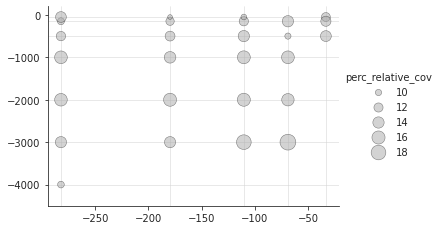

In [14]:
table = merged.groupby(["distance", "depth"], \
                    as_index=False).agg({"perc_relative_cov":"sum"}).sort_values("depth", ascending=False)

sns.set_style("ticks")
kws = dict(linewidth=.5, edgecolor="black")
g = sns.relplot(x="distance", y="depth", color="darkgrey",
    data=table.sort_values(["distance"], ascending=False),
    palette="Set2", size="perc_relative_cov", 
    sizes=(0,250),height=3.5, aspect=1.5,alpha=0.50, **kws, legend="brief")
plt.xlabel("")
plt.ylabel("")
plt.ylim([-4500,200])

for i,ax in enumerate(g.axes.flat):
    
    for k in table["depth"].unique():
        ax.axhline(k, ls="-", zorder=0, linewidth=0.5,color="lightgrey")
    for k in table["distance"].unique():
        ax.axvline(k, ls="-", zorder=0, linewidth=0.5,color="lightgrey")
        
plt.savefig(rootdir + "figures/oc17_distribution_all.svg", format="svg", 
            dpi=300,  bbox_inches="tight", facecolor="white")
plt.show()

### sum by form by sample

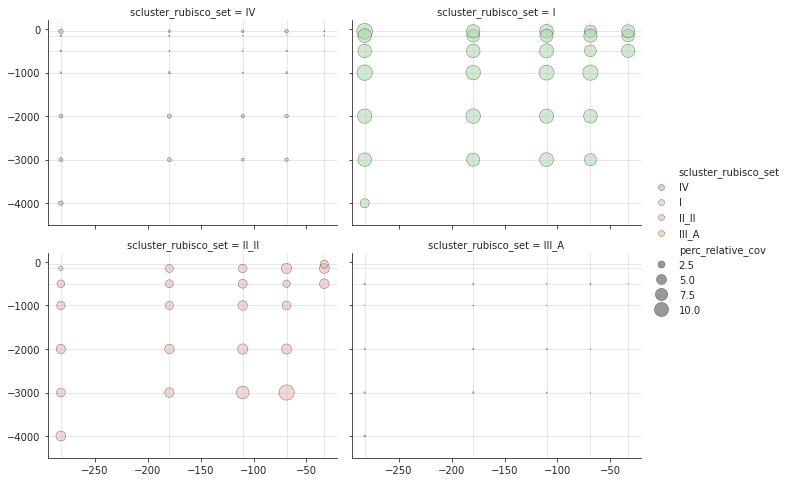

In [43]:
table = merged.groupby(["distance", "depth", "scluster_rubisco_set"], \
                    as_index=False).agg({"perc_relative_cov":"sum"}).sort_values("depth", ascending=False)

sns.set_style("ticks")
kws = dict(linewidth=.5, edgecolor="black")
g = sns.relplot(x="distance", y="depth", hue="scluster_rubisco_set", col="scluster_rubisco_set", col_wrap=2,
    data=table.sort_values(["distance"], ascending=False),
    palette={"I":"#A6D6A6", "II_II":"#E2B2AC", 
             "III_A": "#EDB66E", "IV": "#C798C5", "None":"grey"},
    col_order =["IV", "I", "II_II", "III_A"],
    size="perc_relative_cov", 
    sizes=(0,250),height=3.5, aspect=1.35,alpha=0.50, **kws, 
    legend="brief").set(ylim=(-4500,200)).set(xlabel="").set(ylabel="")

for i,ax in enumerate(g.axes.flat):
    
    for k in table["depth"].unique():
        ax.axhline(k, ls="-", zorder=0, linewidth=0.5,color="lightgrey")
    for k in table["distance"].unique():
        ax.axvline(k, ls="-", zorder=0, linewidth=0.5,color="lightgrey")
        
plt.savefig(rootdir + "figures/oc17_distribution_byform.svg", format="svg", 
            dpi=300,  bbox_inches="tight", facecolor="white")
plt.show()

### by taxonomy

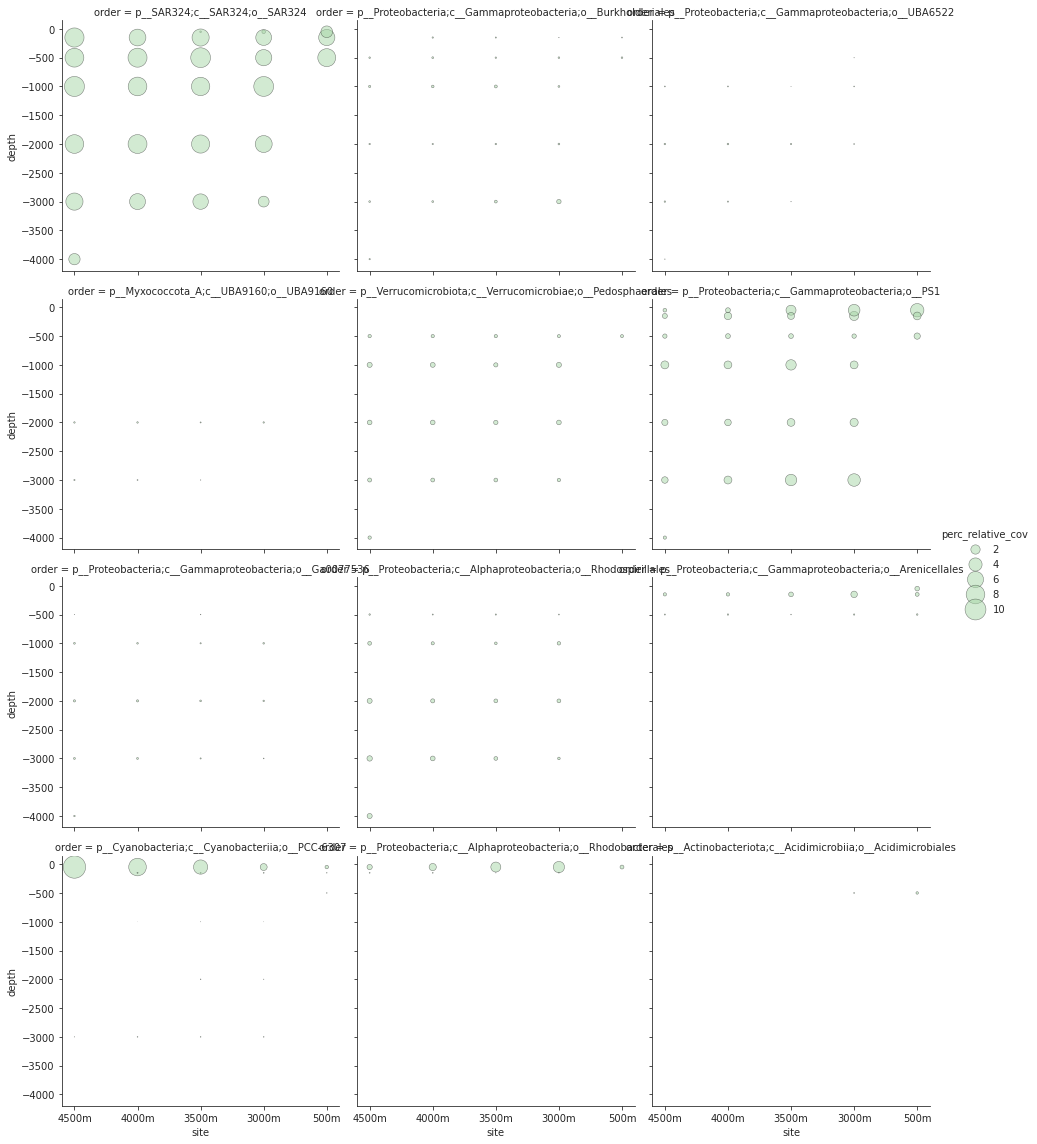

In [37]:
merged["order"] = merged["classification"].apply(lambda x: ";".join(x.split(";")[1:4]))
table = merged.query("scluster_rubisco_set=='I'").groupby(["site", "depth", "order"], \
                    as_index=False).agg({"perc_relative_cov":"sum"}).sort_values("depth", ascending=False)
table["site_numeric"] = table["site"].apply(lambda x: int(x.replace("m", "")))

sns.set_style("ticks")
kws = dict(linewidth=.5, edgecolor="black")
g = sns.relplot(x="site", y="depth", color="#A6D6A6", col="order", col_wrap=3,
    data=table.sort_values(["site_numeric"], ascending=False),
     size="perc_relative_cov", 
    sizes=(0,500),height=4, aspect=1.10,alpha=0.50, **kws, legend="brief")
plt.savefig(rootdir + "figures/oc17_distribution_formI.png", format="png", 
            dpi=300,  bbox_inches="tight", facecolor="white")
plt.show()

In [55]:
sgs = {row["genome"]: row["secondary_cluster"] \
       for key, row in nr_genomes.iterrows()}

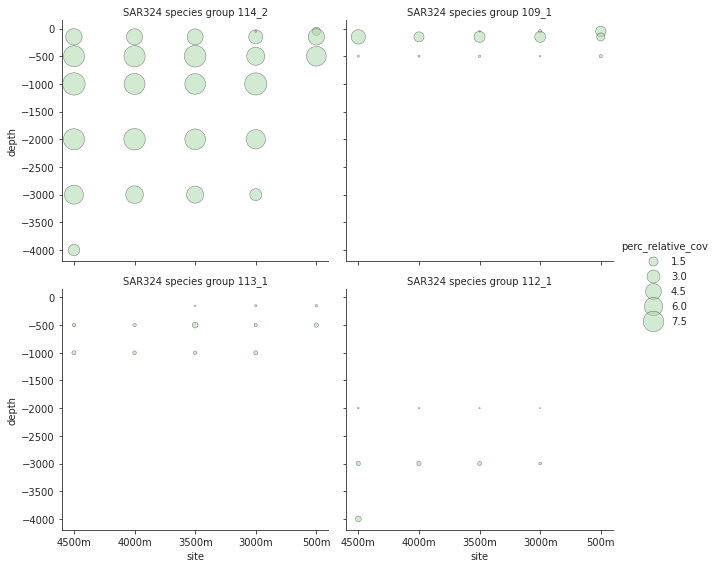

In [59]:
table = merged[(merged["order"].str.contains("SAR324")) & (merged["scluster_rubisco_set"]=='I')].sort_values("depth", ascending=False)
table["species_group"] = table["Genome"].map(sgs)
table["site_numeric"] = table["site"].apply(lambda x: int(x.replace("m", "")))

sns.set_style("ticks")
kws = dict(linewidth=.5, edgecolor="black")
g = sns.relplot(x="site", y="depth", color="#A6D6A6", col="species_group", col_wrap=2,
    data=table.sort_values(["site_numeric"], ascending=False),
     size="perc_relative_cov", 
    sizes=(0,500),height=4, aspect=1.10,alpha=0.50, **kws, legend="brief")
g.set_titles("SAR324 species group {col_name}")
plt.savefig(rootdir + "figures/oc17_distribution_sar324.svg", format="svg", 
            dpi=300,  bbox_inches="tight", facecolor="white")
plt.show()

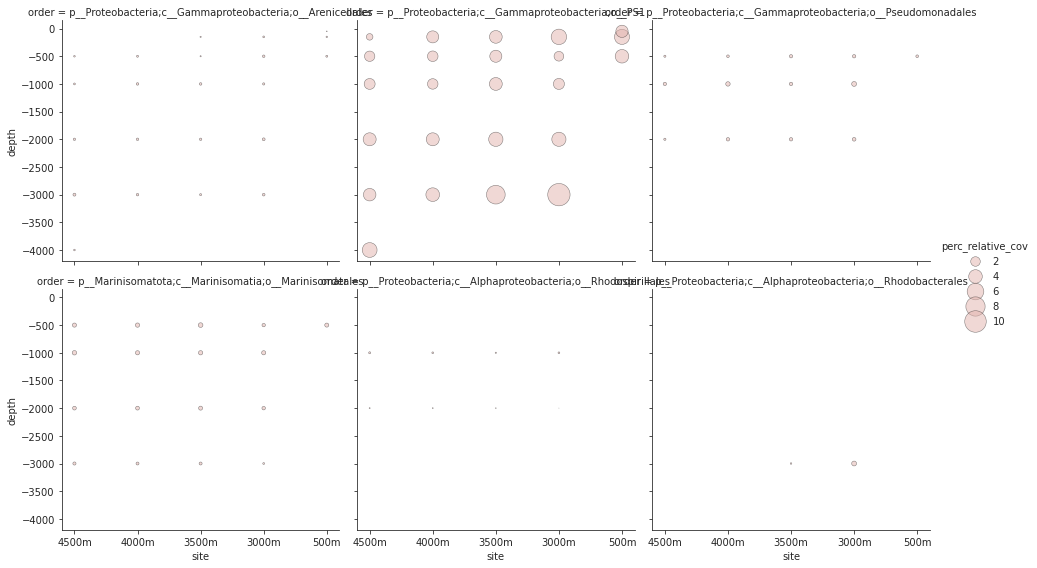

In [60]:
table = merged.query("scluster_rubisco_set=='II_II'").groupby(["site", "depth", "order"], \
                    as_index=False).agg({"perc_relative_cov":"sum"}).sort_values("depth", ascending=False)
table["site_numeric"] = table["site"].apply(lambda x: int(x.replace("m", "")))

sns.set_style("ticks")
kws = dict(linewidth=.5, edgecolor="black")
g = sns.relplot(x="site", y="depth", color="#E2B2AC", col="order", col_wrap=3,
    data=table.sort_values(["site_numeric"], ascending=False),
     size="perc_relative_cov", 
    sizes=(0,500),height=4, aspect=1.10,alpha=0.50, **kws, legend="brief")
plt.savefig(rootdir + "figures/oc17_distribution_formII.png", format="png", 
            dpi=300,  bbox_inches="tight", facecolor="white")
plt.show()

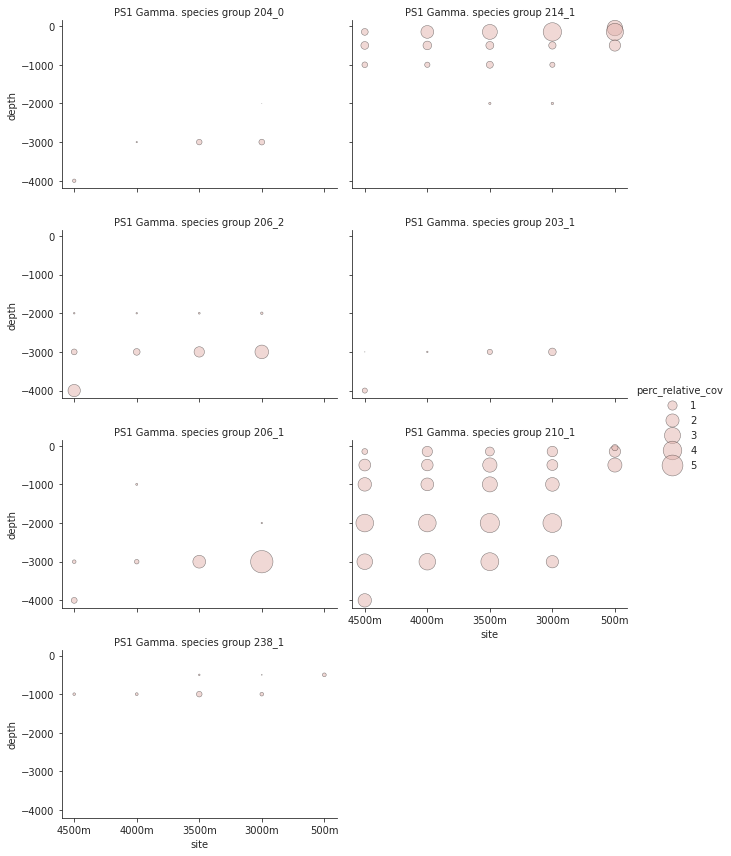

In [73]:
table = merged[(merged["order"].str.contains("PS1")) & (merged["scluster_rubisco_set"]=='II_II')].sort_values("depth", ascending=False)
table["species_group"] = table["Genome"].map(sgs)
table["site_numeric"] = table["site"].apply(lambda x: int(x.replace("m", "")))

sns.set_style("ticks")
kws = dict(linewidth=.5, edgecolor="black")
g = sns.relplot(x="site", y="depth", color="#E2B2AC", col="species_group", col_wrap=2,
    data=table.sort_values(["site_numeric"], ascending=False),
     size="perc_relative_cov", 
    sizes=(0,500),height=3, aspect=1.5,alpha=0.50, **kws, legend="brief")
g.set_titles("PS1 Gamma. species group {col_name}")
plt.savefig(rootdir + "figures/oc17_distribution_ps1.svg", format="svg", 
            dpi=300,  bbox_inches="tight", facecolor="white")
plt.show()

### stacked bars

In [46]:
palette={"I":"#A6D6A6", "II_II":"#E2B2AC", 
         "III_A": "#EDB66E", "IV": "#C798C5", "None":"grey"}

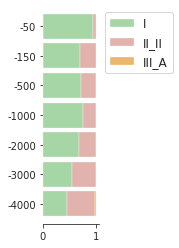

In [48]:
total = merged.query("scluster_rubisco_set!='IV'").groupby(["scluster_rubisco_set", "depth"], \
    as_index=False).agg({"perc_relative_cov":"sum"}).sort_values("depth", ascending=False).rename(columns={"perc_relative_cov":"summed_perc_relative_cov"})
totalgb = total.groupby("depth", as_index=False).aggregate({"summed_perc_relative_cov":"sum"}).rename(columns={"summed_perc_relative_cov":"total_perc_relative_cov"})
total = total.merge(totalgb, how="left", on="depth")
total["perc_total_cov"] = total.apply(lambda x: x["summed_perc_relative_cov"]/x["total_perc_relative_cov"], axis=1)

total_piv = total.pivot(index="depth", columns="scluster_rubisco_set", values="perc_total_cov").fillna(0)
row_order = sorted(total["depth"].unique(), reverse=False)
form_order = ["I", "II_II", "III_A"]
total_piv[form_order].loc[row_order,].plot.barh(color=[palette[form] for form in form_order], width=0.85,stacked=True, 
    linewidth=0.3, figsize=(1,4), legend=None)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize=12)
plt.ylabel("")
sns.despine(bottom=False, left=True)
plt.savefig(rootdir + "figures/oc17_distribution_byform_bar.svg", format="svg", 
            dpi=300,  bbox_inches="tight", facecolor="white")
plt.show()

In [49]:
def assign_label(taxstring):
    
    s = taxstring.split(";")
    if "Proteobacteria" in taxstring:
        return "%s;%s" %(s[1], s[2])
    else: return "%s;%s" %(s[0], s[2])

In [50]:
p = list(sns.color_palette("tab20c").as_hex())
color_mapping = {'c__Alphaproteobacteria;o__Rhodobacterales': p[0],
                 'c__Alphaproteobacteria;o__Rhodospirillales': p[1],
                 'c__Gammaproteobacteria;o__Arenicellales':p[12],
                 'c__Gammaproteobacteria;o__Burkholderiales': p[13],
                 'c__Gammaproteobacteria;o__PS1':p[14],
                 'c__Gammaproteobacteria;o__Pseudomonadales':p[15],
                 'p__Cyanobacteria;o__PCC-6307': p[8],
                 'p__Marinisomatota;o__Marinisomatales': p[4],
                 'p__SAR324;o__SAR324': p[5],
                 'p__Verrucomicrobiota;o__Pedosphaerales': p[6],
                 'p__Thermoproteota;o__Nitrososphaerales': p[7],
                 'other': p[-1]}

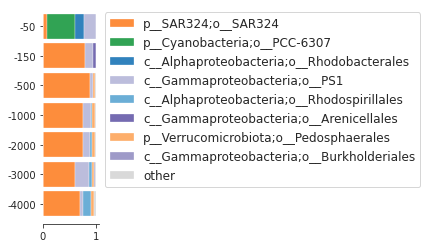

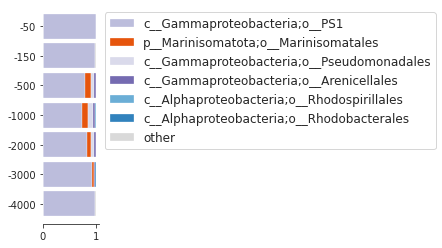

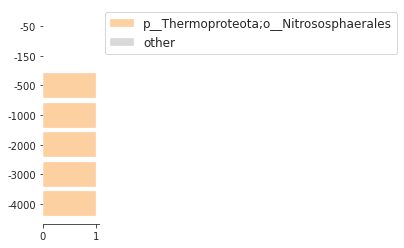

In [52]:
for form in merged["scluster_rubisco_set"].unique():
    
    if form != "IV":
        
        table = merged[merged["scluster_rubisco_set"]==form]
        total = table.groupby(["order", "depth"], \
            as_index=False).agg({"perc_relative_cov":"sum"}).sort_values("depth", ascending=False).rename(columns={"perc_relative_cov":"summed_perc_relative_cov"})
        totalgb = total.groupby("depth", as_index=False).aggregate({"summed_perc_relative_cov":"sum"}).rename(columns={"summed_perc_relative_cov":"total_perc_relative_cov"})
        total = total.merge(totalgb, how="left", on="depth")
        total["perc_total_cov"] = total.apply(lambda x: x["summed_perc_relative_cov"]/x["total_perc_relative_cov"], axis=1)
        # filter out anything with less than 2% of total
        total["display_name"] = total.apply(lambda x: assign_label(x["order"]) if x["perc_total_cov"]>0.02 else "other", axis=1)
        
        # add in depth dummies if needed
        for depth in merged["depth"].unique():
            if depth not in total["depth"].unique():
                total = pd.concat([total, pd.DataFrame.from_dict({"order":["other"], "depth": [depth], 
                        "perc_total_cov":[0], "display_name": ["other"]})])
                
        # recombine otherses if multiple
        newgb = total.groupby(["display_name", "depth"], as_index=False).aggregate({"perc_total_cov":"sum"}).sort_values("depth")
        
        new_piv = newgb.pivot(index="depth", columns="display_name", values="perc_total_cov").fillna(0)
        row_order = sorted(total["depth"].unique(), reverse=False)
        group_order = total.groupby("display_name").aggregate({"perc_total_cov":"mean"}).sort_values("perc_total_cov", ascending=False).index
        new_piv[group_order].loc[row_order,].plot.barh(color=[color_mapping[group] for group in group_order], width=0.85,stacked=True, 
            linewidth=0.3, figsize=(1,4), legend=None)
        plt.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize=12)
        plt.ylabel("")
        sns.despine(bottom=False, left=True)
        plt.savefig(rootdir + "figures/oc17_distribution_form%s_bar.svg" %(form), format="svg", 
                    dpi=300,  bbox_inches="tight", facecolor="white")
        plt.show()

### by metabolic pathway

Aerobic Hydrogen Oxidation


/tmp/ipykernel_29595/869530822.py:17: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  g = sns.relplot(x="distance", y="depth", color="#DB8937",


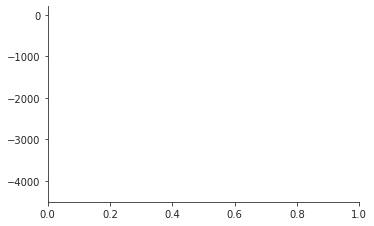

Ammonia oxidation


/tmp/ipykernel_29595/869530822.py:17: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  g = sns.relplot(x="distance", y="depth", color="#DB8937",


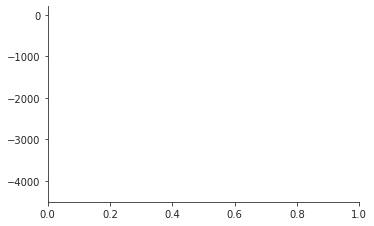

Nitrite oxidation


/tmp/ipykernel_29595/869530822.py:17: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  g = sns.relplot(x="distance", y="depth", color="#DB8937",


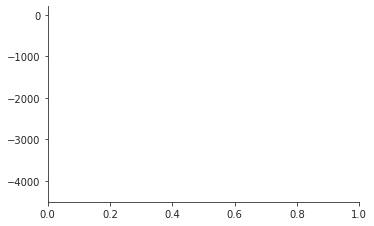

Sulfide oxidation


/tmp/ipykernel_29595/869530822.py:17: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  g = sns.relplot(x="distance", y="depth", color="#DB8937",


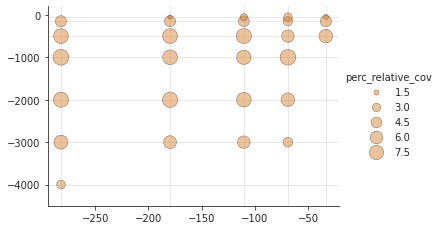

Sulfite oxidation


/tmp/ipykernel_29595/869530822.py:17: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  g = sns.relplot(x="distance", y="depth", color="#DB8937",


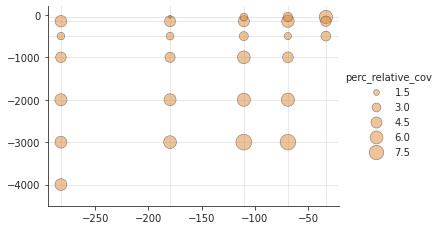

Sulfite production from org. sulfur


/tmp/ipykernel_29595/869530822.py:17: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  g = sns.relplot(x="distance", y="depth", color="#DB8937",


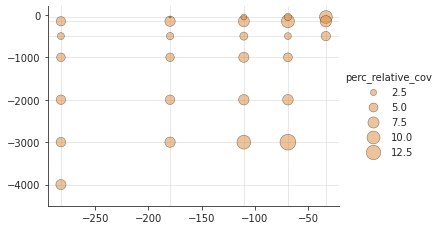

Sulfur oxidation


/tmp/ipykernel_29595/869530822.py:17: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  g = sns.relplot(x="distance", y="depth", color="#DB8937",


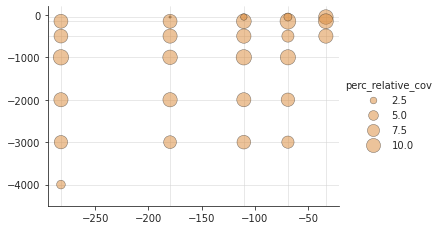

Thiosulfate disproportionation


/tmp/ipykernel_29595/869530822.py:17: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  g = sns.relplot(x="distance", y="depth", color="#DB8937",


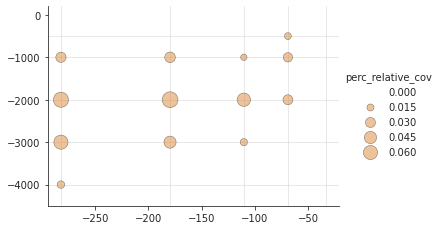

Thiosulfate oxidation


/tmp/ipykernel_29595/869530822.py:17: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  g = sns.relplot(x="distance", y="depth", color="#DB8937",


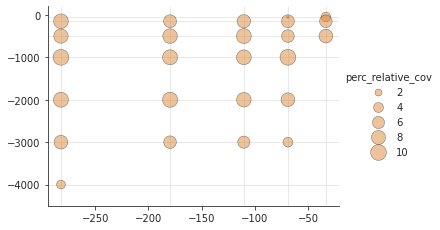

In [54]:
for function in pathways["function"].unique():
    
    print(function)
    # pull all genomes with function of interest
    all_genomes = pathways[pathways["function"]==function]["genome_name"].to_list()
    # then, probe abundance information
    table = merged[merged["Genome"].isin(all_genomes)].groupby(["distance", "depth"], \
                    as_index=False).agg({"perc_relative_cov":"sum"}).sort_values("depth", ascending=False)

    # add in missing vals for plot standardization
    if "disprop" in function:
        table = pd.concat([table, pd.DataFrame.from_dict({"distance": [-33.15], "depth": [-500], \
                    "perc_relative_cov": [0]}, orient='columns')])

    sns.set_style("ticks")
    kws = dict(linewidth=.5, edgecolor="black")
    g = sns.relplot(x="distance", y="depth", color="#DB8937",
        data=table.sort_values(["distance"], ascending=False),
        palette="Set2", size="perc_relative_cov", 
        sizes=(0,250),height=3.5, aspect=1.5,alpha=0.50, **kws, legend="brief")
    plt.xlabel("")
    plt.ylabel("")
    plt.ylim([-4500,200])

    for i,ax in enumerate(g.axes.flat):

        for k in table["depth"].unique():
            ax.axhline(k, ls="-", zorder=0, linewidth=0.5,color="lightgrey")
        for k in table["distance"].unique():
            ax.axvline(k, ls="-", zorder=0, linewidth=0.5,color="lightgrey")

    plt.savefig(rootdir + "figures/oc17_distribution_" + function.replace(" ", "_") + ".svg", format="svg", 
                dpi=300,  bbox_inches="tight", facecolor="white")
    plt.show()

## supp

In [15]:
site_dict = {"500m": "OC2", "3000m": "OC3", "3500m":"OC4", "4000m": "OC5", "4500m":"OC6"}

In [ ]:
supp = merged[["site", "depth", "distance", "Genome", "Covered Fraction", "perc_relative_cov", \
               "scluster_rubisco_set", "classification"]]
supp["new_site"] = supp["site"].map(site_dict)
supp["sample"] = supp.apply(lambda x: "_".join([x["new_site"],str(x["depth"]*-1)+"m"]), axis=1)
supp["order"] = supp["classification"].apply(lambda x: ";".join(x.split(";")[0:4]))
supp["approx_distance_km"] = supp["distance"].apply(lambda x: x*-1)
supp.sort_values(["new_site", "depth"], ascending=[True,False])[["sample", "approx_distance_km", "Genome", "order", \
      "scluster_rubisco_set", "perc_relative_cov", "Covered Fraction"]].to_csv(rootdir + "tables/table_s7.tsv", sep="\t", index=False)